# part0: imports

In [3]:
import os, sys, pathlib
from pprint import pprint 
from importlib import reload
import logging
logging.basicConfig(level=logging.ERROR)
import warnings
warnings.simplefilter("ignore")


import pandas as pd
import numpy as np
import xarray as xr
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator


from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal

%matplotlib inline

root= pathlib.Path("/data")

A second order wrapper for `dt.canoncorr` to make it link with `PyalData`.

In [5]:
def CCA_pyal(df1:pd.DataFrame, field1: str, df2:pd.DataFrame =None, field2:str =None) -> np.array:
    if df2 is None:
        assert isinstance(field2,str), 'Enter a valid string in field2'
        df2 = df1

    d0 = np.concatenate(df1[field1].values, axis=0)
    d1 = np.concatenate(df2[field2].values, axis=0)

    # same number of timepoints in both matrices
    n_samples = min ([d0.shape[0], d1.shape[0]])
    d0 = d0[:n_samples,:]
    d1 = d1[:n_samples,:]

    CC = dt.canoncorr(d0, d1)

    return CC

# Compare similar target in 2 animals

In [6]:
animalList = ['Chewie', 'Mihili']

animalFiles={}
for animal in animalList:
    animalFiles[animal] = utility.find_file(root / animal,'mat')

# just keeping the CS sessions
goodFiles = [file for animal in animalFiles for file in animalFiles[animal] if 'CS' in file]
pprint(goodFiles)

# keeping 1 session per animal
fileList = ['/data/Chewie/Chewie_CO_CS_2016-10-14.mat', '/data/Mihili/Mihili_CO_VR_2014-03-03.mat']

['/data/Chewie/Chewie_CO_CS_2016-10-14.mat',
 '/data/Chewie/Chewie_CO_CS_2016-10-21.mat',
 '/data/Mihili/Mihili_CO_CS_2015-05-12.mat',
 '/data/Mihili/Mihili_CO_CS_2015-05-11.mat',
 '/data/Mihili/Mihili_CO_CS_2014-06-26.mat',
 '/data/Mihili/Mihili_CO_CS_2014-06-27.mat',
 '/data/Mihili/Mihili_CO_CS_2014-09-29.mat',
 '/data/Mihili/Mihili_CO_CS_2014-12-03.mat']


In [7]:
df_data=[]
for fname in fileList:
    df = pyal.mat2dataframe(fname, shift_idx_fields=True)
    df_data.append(df)


all the preprocessing steps

In [8]:
def prep_pyalData (df):
    df_= pyal.add_firing_rates(df, 'smooth')
    df_= pyal.select_trials(df_, df_.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    df_= pyal.select_trials(df_, df_.target_direction < -2)
    
    df_ = pyal.remove_low_firing_neurons(df_, "M1_spikes", 1)
    df_ = pyal.remove_low_firing_neurons(df_, "PMd_spikes", 1)
    
    df_ = pyal.restrict_to_interval(df_, start_point_name='idx_movement_on', rel_start=0, rel_end=30)
    
    M1_rates = np.concatenate(df_.M1_rates.values, axis=0)
    pca_model = PCA(n_components=20, svd_solver='full');
    pca_model.fit(M1_rates);
    df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'M1_rates', 'M1_pca');

    PMd_rates = np.concatenate(df_.PMd_rates.values, axis=0)
    pca_model = PCA(n_components=20, svd_solver='full');
    pca_model.fit(PMd_rates);
    df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'PMd_rates', 'PMd_pca');

    
    return df_

Prep both sessions

In [9]:
df_data_ = [prep_pyalData(df) for  df in df_data]

plot the CCs across animals, to one target

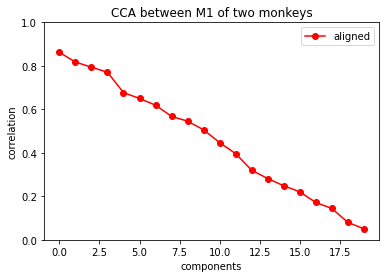

In [10]:
d0_M1 = np.concatenate(df_data_[0].M1_pca.values, axis=0)
d1_M1 = np.concatenate(df_data_[1].M1_pca.values, axis=0)

# same number of timepoints in both matrices
n_samples_M1 = min ([d0_M1.shape[0], d1_M1.shape[0]])
d0_M1_ = d0_M1[:n_samples_M1,:]
d1_M1_ = d1_M1[:n_samples_M1,:]

CC_M1 = dt.canoncorr(d0_M1_, d1_M1_)

_,ax = plt.subplots()

ax.plot(CC_M1, 'r-o', label='aligned')

ax.set_xlabel('components')
ax.set_ylabel('correlation')
ax.legend()
ax.set_ylim([0,1])
ax.set_title('CCA between M1 of two monkeys');

#### BE WARE!

results depend on the initial number of PCs, i.e., features in the data matrix.
For 10 PCs, the max CC will be 0.75 instead of 0.85

---
Next, let's add to the plot above, within monkey M1 CCs.

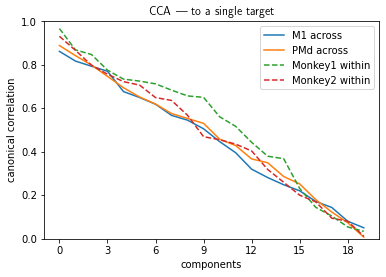

In [11]:
d0_PMd = np.concatenate(df_data_[0].PMd_pca.values, axis=0)
d1_PMd = np.concatenate(df_data_[1].PMd_pca.values, axis=0)

# same number of timepoints in both matrices
n_samples_d0 = min ([d0_M1.shape[0], d0_PMd.shape[0]])
n_samples_d1 = min ([d1_M1.shape[0], d1_PMd.shape[0]])
d0_PMd_ = d0_PMd[:n_samples_d0,:]
d1_PMd_ = d1_PMd[:n_samples_d1,:]
n_samples_PMd = min ([d0_PMd.shape[0], d1_PMd.shape[0]])
d0_PMd_ = d0_PMd[:n_samples_PMd,:]
d1_PMd_ = d1_PMd[:n_samples_PMd,:]



CC_d0 = dt.canoncorr(d0_M1_, d0_PMd_)
CC_d1 = dt.canoncorr(d1_M1_, d1_PMd_)
CC_PMd= dt.canoncorr(d0_PMd_, d1_PMd_)

_,ax = plt.subplots()

ax.plot(CC_M1, label='M1 across')
ax.plot(CC_PMd, label='PMd across')
ax.plot(CC_d0,'--', label='Monkey1 within')
ax.plot(CC_d1,'--', label='Monkey2 within')

ax.set_xlabel('components')
ax.set_ylabel('canonical correlation')
ax.legend()
ax.set_ylim([0,1])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('CCA --- to a single target', usetex=True);

average over every target

In [12]:
def get_target_id(trial):
    return int(np.round((trial.target_direction + np.pi) / (0.25*np.pi))) - 1

def prep_pyalData_all_targets (df):
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    df_= pyal.add_firing_rates(df, 'smooth')
    df_= pyal.select_trials(df_, df_.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    df_ = pyal.remove_low_firing_neurons(df_, "M1_spikes", 1)
    df_ = pyal.remove_low_firing_neurons(df_, "PMd_spikes", 1)
    
    df_ = pyal.restrict_to_interval(df_, start_point_name='idx_movement_on', rel_start=0, rel_end=30)
    
    M1_rates = np.concatenate(df_.M1_rates.values, axis=0)
    pca_model = PCA(n_components=20, svd_solver='full');
    pca_model.fit(M1_rates);
    df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'M1_rates', 'M1_pca');

    PMd_rates = np.concatenate(df_.PMd_rates.values, axis=0)
    pca_model = PCA(n_components=20, svd_solver='full');
    pca_model.fit(PMd_rates);
    df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'PMd_rates', 'PMd_pca');

    
    return df_


df_data__ = [prep_pyalData_all_targets(df) for  df in df_data]

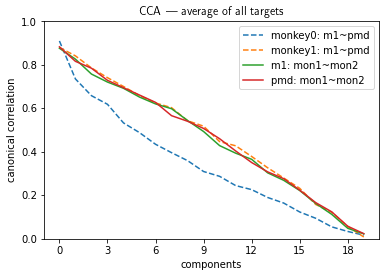

In [14]:
fig,ax = plt.subplots()

CC=[]
for target in range(8):
    dfs = [pyal.select_trials(df_,df_.target_id==target) for df_ in df_data__]
    
    # monkey0: m1~pmd
    CC.append(CCA_pyal(dfs[0],'M1_pca', dfs[0],'PMd_pca'))
    # monkey1: m1~pmd
    CC.append(CCA_pyal(dfs[1],'M1_pca', dfs[1],'PMd_pca'))
    # m1: mon1~mon2
    CC.append(CCA_pyal(dfs[0],'M1_pca', dfs[1],'M1_pca'))
    # pmd: mon1~mon2
    CC.append(CCA_pyal(dfs[0],'PMd_pca', dfs[1],'PMd_pca'))

CC= np.array(CC)

ax.plot(np.mean(CC[0::8,:],axis=0),'--',label='monkey0: m1~pmd')
ax.plot(np.mean(CC[1::8,:],axis=0),'--',label='monkey1: m1~pmd')
ax.plot(np.mean(CC[2::8,:],axis=0),label='m1: mon1~mon2')
ax.plot(np.mean(CC[3::8,:],axis=0),label='pmd: mon1~mon2')

ax.set_xlabel('components')
ax.set_ylabel('canonical correlation')
ax.legend()
ax.set_ylim([0,1])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('CCA --- average of all targets', usetex=True);

let's also add inter target CCA in individual animals

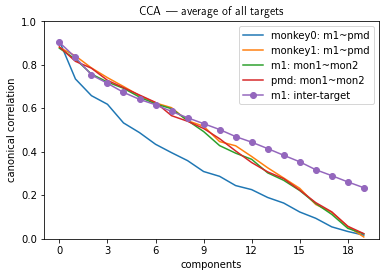

In [15]:
fig,ax = plt.subplots()

target_CC=[]
for target0 in range(8):
    dfs0 = [pyal.select_trials(df_,df_.target_id==target0) for df_ in df_data__]
    for target1 in range(target0,8):
        dfs1 = [pyal.select_trials(df_,df_.target_id==target1) for df_ in df_data__]
        
        target_CC.append(CCA_pyal(dfs0[0],'M1_pca', dfs1[0],'M1_pca'))
        target_CC.append(CCA_pyal(dfs0[1],'M1_pca', dfs1[1],'M1_pca'))

target_CC= np.array(target_CC)


ax.plot(np.mean(CC[0::8,:],axis=0),label='monkey0: m1~pmd')
ax.plot(np.mean(CC[1::8,:],axis=0),label='monkey1: m1~pmd')
ax.plot(np.mean(CC[2::8,:],axis=0),label='m1: mon1~mon2')
ax.plot(np.mean(CC[3::8,:],axis=0),label='pmd: mon1~mon2')

ax.plot(np.mean(target_CC,axis=0),'o-',label='m1: inter-target')

ax.set_xlabel('components')
ax.set_ylabel('canonical correlation')
ax.legend()
ax.set_ylim([0,1])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('CCA --- average of all targets', usetex=True);

## Ideas:
+ **Explained variance**:
>it'd be interesting to look at the variance explained by the shared dimensions though (both within monkey and across).

Calculating the explained variance could be through the method outlined in the paper: "Cortical population activity within a preserved neural manifold underlies multiple motor behaviors"

+ **Fewer PCs**: So far, CCA has converged in every case.
Might be due to 20 PCs as input which gives CCA all the information it can ask for!

+ **stability**: use the same transformations for aligning later sessions, hoping M1-PMd drops in accuracy and M1-M1 across animals, doesn't?!

+ **non-movement epochs**: If the idea is that CCA reveals the underlying structure, CC axes should generalise across different time point in a trial;
i.e., post stimulus and post movement, ...


---
Now, let's decode animals behaviour based on other animal's activity